<a href="https://colab.research.google.com/github/rogerwender/CientistaDeDados/blob/main/Prevendo_Fadiga_de_Funcion%C3%A1rios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise do seguinte problema:
#*Prever a taxa de esgotamento dos funcionários com base nos recursos fornecidos*
Obs.: análise de dados de uma empresa fictícia

#Análisando os Dados


#### Fontes:
https://www.kaggle.com/redwankarimsony/hackerearth-employee-burnout-challenge


Descrição dos campos:
- Employee ID : ID do funcionário
- Date of joining: Data admissão na empresa
- Gender: Sexo
- Company Type: Tipo da empresa
- WFH Setup Available: Configuração adequada está disponível ou não em casa
- Designation: nível de antiguidade do funcionário
- Resource Allocation: Horas de trabalho por dia
- Mental Fatigue Score: pontuação da fadiga mental.
- Burn Rate: taxa de saturação.

In [105]:
# Bibliotecas importadas para utilização no projeto
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import  train_test_split

#import lightgbm and xgboost 
import lightgbm as lgb 
import xgboost as xgb 

# Avaliação da Máquina Preditiva
from sklearn.metrics import mean_squared_error, r2_score
import math

In [106]:
# Importando o dataset
dados = pd.read_csv("/content/Dados.csv",sep = ",")

#Vendo as primeiras linhas
print("Total de linhas e colunas: ", dados.shape)


Total de linhas e colunas:  (22750, 9)


In [107]:
dados.head(5)

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [108]:
dados.rename(columns= {'Employee ID': 'ID', 
                       'Date of Joining':'Data_Ingresso',
                       'Gender':'Sexo', 
                       'Company Type':'Tipo_Empresa',
                       'WFH Setup Available':'Configuracao_Disponivel',
                       'Designation':'Nivel_Antiguidade',
                       'Resource Allocation':'Horas_Alocadas',
                       'Mental Fatigue Score':'Pontos_Fadiga_Mental',
                       'Burn Rate':'Taxa_Saturacao'
             }, inplace=True)


## Explorando os dados/variáveis

In [ ]:
dados['ID'].value_counts()
sns.countplot(dados['ID'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


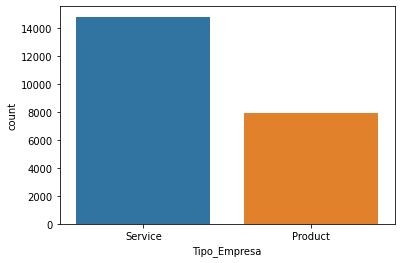

In [109]:
dados['Tipo_Empresa'].value_counts()
sns.countplot(dados['Tipo_Empresa'])


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


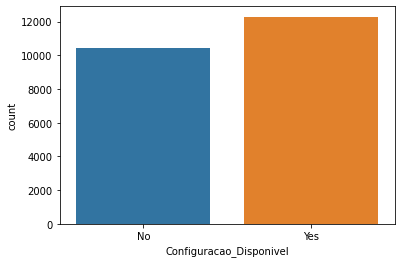

In [110]:
dados['Configuracao_Disponivel'].value_counts()
sns.countplot(dados['Configuracao_Disponivel'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


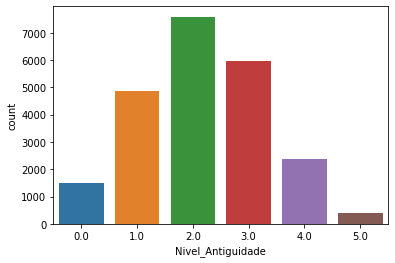

In [111]:
dados.Nivel_Antiguidade.value_counts()
sns.countplot(dados.Nivel_Antiguidade)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


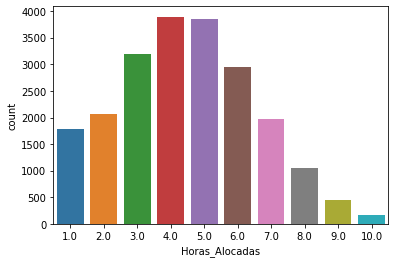

In [112]:
dados.Horas_Alocadas.value_counts()
sns.countplot(dados.Horas_Alocadas)

In [113]:
# Verificando valores nulos
dados.isna().sum()

ID                            0
Data_Ingresso                 0
Sexo                          0
Tipo_Empresa                  0
Configuracao_Disponivel       0
Nivel_Antiguidade             0
Horas_Alocadas             1381
Pontos_Fadiga_Mental       2117
Taxa_Saturacao             1124
dtype: int64

In [114]:
#Verificando valores nulos por percentual
dados.isnull().mean()*100

ID                         0.000000
Data_Ingresso              0.000000
Sexo                       0.000000
Tipo_Empresa               0.000000
Configuracao_Disponivel    0.000000
Nivel_Antiguidade          0.000000
Horas_Alocadas             6.070330
Pontos_Fadiga_Mental       9.305495
Taxa_Saturacao             4.940659
dtype: float64

In [115]:
dados.describe()

,Nivel_Antiguidade,Horas_Alocadas,Pontos_Fadiga_Mental,Taxa_Saturacao
count,22750.000000,21369.000000,20633.000000,21626.000000
mean,2.178725,4.481398,5.728188,0.452005
std,1.135145,2.047211,1.920839,0.198226
min,0.000000,1.000000,0.000000,0.000000
25%,1.000000,3.000000,4.600000,0.310000
50%,2.000000,4.000000,5.900000,0.450000
75%,3.000000,6.000000,7.100000,0.590000
max,5.000000,10.000000,10.000000,1.000000


# Preparando os dados para Processamento dos Dados

In [116]:
#função para buscar o total de dias
def create_days_count(data_ingresso):
    return (current_date - data_ingresso["Data_Ingresso"])

In [117]:
# Convertendo a Data_Ingresso para o formato datetime
dados["Data_Ingresso"] = pd.to_datetime(dados["Data_Ingresso"])

### Retirando os Valores Nulos (NaN) - substituídos pela média da coluna

In [118]:
# Inserindo valores (media) nas linhas 'nulos' nas três colunas abaixo
valores_nulos=['Horas_Alocadas','Pontos_Fadiga_Mental','Taxa_Saturacao']
dados[valores_nulos]=dados[valores_nulos].replace({np.nan:dados['Horas_Alocadas'].mean(),
                                                  np.nan:dados['Taxa_Saturacao'].mean(),
                                                  np.nan:dados['Pontos_Fadiga_Mental'].mean(),
                                                 })

In [119]:
# Após a substituição dos valores nulos pela media da coluna podemos verificar que não existem mais valores nulos
dados.isnull().mean()*100

ID                         0.0
Data_Ingresso              0.0
Sexo                       0.0
Tipo_Empresa               0.0
Configuracao_Disponivel    0.0
Nivel_Antiguidade          0.0
Horas_Alocadas             0.0
Pontos_Fadiga_Mental       0.0
Taxa_Saturacao             0.0
dtype: float64

#### Engenharia de Atributos - Criando campo "dias de trabalho"

In [120]:
# Buscando a data atual
current_date = pd.to_datetime('today')

# Criando a coluna dias_trabalho
dados["Dias_Trabalho"] = dados.apply(create_days_count, axis=1).dt.days

In [121]:
dados.head()

,ID,Data_Ingresso,Sexo,Tipo_Empresa,Configuracao_Disponivel,Nivel_Antiguidade,Horas_Alocadas,Pontos_Fadiga_Mental,Taxa_Saturacao,Dias_Trabalho
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.000000,3.8,0.16,4674
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.000000,5.0,0.36,4613
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,5.728188,5.8,0.49,4878
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.000000,2.6,0.20,4640
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.000000,6.9,0.52,4742


#### LabelEncoder - Variáveis não numéricas

In [122]:
dados['Sexo']=dados['Sexo'].map({'Male':1,'Female':0})

In [123]:
dados['Tipo_Empresa']=dados['Tipo_Empresa'].map({'Service':1,'Product':0})

In [124]:
dados['Configuracao_Disponivel']=dados['Configuracao_Disponivel'].map({'Yes':1,'No':0})

In [125]:
dados.head()

,ID,Data_Ingresso,Sexo,Tipo_Empresa,Configuracao_Disponivel,Nivel_Antiguidade,Horas_Alocadas,Pontos_Fadiga_Mental,Taxa_Saturacao,Dias_Trabalho
0,fffe32003000360033003200,2008-09-30,0,1,0,2.0,3.000000,3.8,0.16,4674
1,fffe3700360033003500,2008-11-30,1,1,1,1.0,2.000000,5.0,0.36,4613
2,fffe31003300320037003900,2008-03-10,0,0,1,2.0,5.728188,5.8,0.49,4878
3,fffe32003400380032003900,2008-11-03,1,1,1,1.0,1.000000,2.6,0.20,4640
4,fffe31003900340031003600,2008-07-24,0,1,0,3.0,7.000000,6.9,0.52,4742


In [126]:
dados.describe()

,Sexo,Tipo_Empresa,Configuracao_Disponivel,Nivel_Antiguidade,Horas_Alocadas,Pontos_Fadiga_Mental,Taxa_Saturacao,Dias_Trabalho
count,22750.000000,22750.000000,22750.000000,22750.000000,22750.000000,22750.000000,22750.000000,22750.000000
mean,0.476571,0.652000,0.540220,2.178725,4.557083,5.728188,0.712684,4764.605495
std,0.499462,0.476346,0.498391,1.135145,2.006312,1.829281,1.159673,105.348190
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4582.000000
25%,0.000000,0.000000,0.000000,1.000000,3.000000,4.700000,0.320000,4674.000000
50%,0.000000,1.000000,1.000000,2.000000,5.000000,5.728188,0.470000,4764.000000
75%,1.000000,1.000000,1.000000,3.000000,6.000000,6.900000,0.610000,4856.000000
max,1.000000,1.000000,1.000000,5.000000,10.000000,10.000000,5.728188,4947.000000


### Eliminando Variáveis que não são explicativas para a previsão

In [127]:
# Excluindo as colunas ID e Data_Ingresso
dados.drop(["ID","Data_Ingresso"],axis=1,inplace=True)

In [128]:
dados.head()

,Sexo,Tipo_Empresa,Configuracao_Disponivel,Nivel_Antiguidade,Horas_Alocadas,Pontos_Fadiga_Mental,Taxa_Saturacao,Dias_Trabalho
0,0,1,0,2.0,3.000000,3.8,0.16,4674
1,1,1,1,1.0,2.000000,5.0,0.36,4613
2,0,0,1,2.0,5.728188,5.8,0.49,4878
3,1,1,1,1.0,1.000000,2.6,0.20,4640
4,0,1,0,3.0,7.000000,6.9,0.52,4742


In [129]:
# criando variáveis x e y para treinamento do modelo. "y" será a coluna a ser comparada
y= dados.pop("Pontos_Fadiga_Mental")
X= dados

In [132]:
y.head()

0    3.8
1    5.0
2    5.8
3    2.6
4    6.9
Name: Pontos_Fadiga_Mental, dtype: float64

### Fazendo a Amostragem dos Dados

In [133]:
# Dividindo os dados X e Y em treino e teste usando Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state= 42)

# Verificando o tamanho dos dados apos split
print("Tamanho do X_treino:", X_train.shape)
print("Tamanho do X_teste:", X_test.shape)
print("Tamanho do y_treino:", y_train.shape)
print("Tamanho do y_teste:", y_test.shape)

Tamanho do X_treino: (18200, 7)
Tamanho do X_teste: (4550, 7)
Tamanho do y_treino: (18200,)
Tamanho do y_teste: (4550,)


# Construíndo a Máquina Preditiva - XGBRegressor


In [134]:
# Construindo o modelo com XGBRegressor
xgb_model = xgb.XGBRegressor()

In [135]:
# treinamento da maquina preditiva para gerar os hiperparametros
xgb_model.fit(X_train, y_train)

[17:06:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [136]:
# predição do modelo
y_predict= xgb_model.predict(X_test)

# Avaliação da Máquina Preditiva - XGBRegressor

In [137]:
# Calcula a métrica R2 do modelo * XGBRegressor*
resultado_xgb = r2_score(y_test, xgb_model.fit(X_train, y_train).predict(X_test))
# resultado_xgb = r2_score(y_test, y_predict)
print("Acurácia usando XGBRegressor: ", resultado_xgb)

[17:06:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Acurácia usando XGBRegressor:  0.8160634088228313


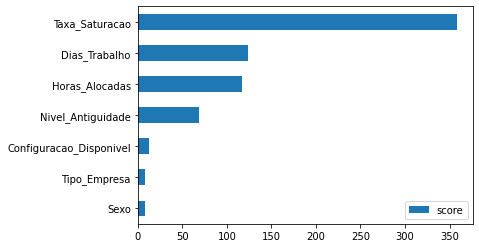

In [138]:
#Construir um gráfico de barras para definir as variáveis mais importantes
feature_important = xgb_model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

dados2 = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending= True)
dados2.plot(kind='barh')

Concluindo: a taxa de saturação é a váriavel mais importante a ser considerada na avaliação e tomada de decisão

# Construíndo a Máquina Preditiva - LGBMRegressor


In [ ]:
## Construindo o modelo com LGBMRegressor
lgb_model = lgb.LGBMRegressor(n_estimators=200)

In [ ]:
# Treinamento
lgb_model.fit(X_train, y_train)

In [ ]:
# Predição do modelo
y_predict= lgb_model.predict(X_test)

# Avaliação da Máquina Preditiva - LGBMRegressor

In [95]:
# Calcula a métrica R2 (modelo de regressão) do modelo LGBMRegressor
resultado_lgbm = r2_score(y_test, lgb_model.fit(X_train, y_train).predict(X_test))
print("Acurácia usando LGBMRegressor: ", resultado_lgbm)

[16:56:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Acurácia usando XGBRegressor:  0.8160634088228313


XGB R2 = 0.8160

LGB R2 = 0.8050
